# Learn to Score a Tic-Tac-Toe Board by Example

## Introduction 


We want to use machine learning (ML) to support intelligent agents playing Tic-Tac-Toe (see [rules](https://en.wikipedia.org/wiki/Tic-tac-toe)). The idea is to learn an evaluation function that can be used in making the decision for the next move. A simple evaluation function $$h: S \rightarrow [-1, 1]$$ which maps each possible board $x \in S$ to a utility value in the range of  -1 to +1. This can be implemented with hand-crafted rules or a weighted sum using features of the board. A simple implementation would be a table that records the utility value for each possible board. Such a table is too large, so we use ML to learn an approximate function using data. ML models are typically very compact and use the fact that similar boards have similar utility values.

Here is a simple approach:

1. Simulate playouts to create labeled training data. The data $X$ is the board, and the label $y$ indicates if the game resulted in a win or a loss.
2. Use the data to learn an evaluation function implemented as a model to predict the probability that we will win a given board. More specifically, we will learn here a function that predicts a score normalized to a probability of a win for each board (i.e., $\hat{P}(y = \mathrm{win} | x) = h(x)$).
3. The model can be applied as:
   - the heuristic evaluation function for Heuristic Minimax Search.
   - a playout policy for better simulated games used in Pure Monte Carlo Search/Monte Carlo Tree Search.
   
An even better approach would be to use "self-play." Here we use the current model as the playout policy for two copies if the agents playing each other (it is called delf-play because the agent basically plays itself). We update the model after each new game finishes and keep on playing. The idea is that the agent will generate a better and better data to improve the evaluation function. Considerations for self-play including temporal credit assignment and the need to introduce variability into the process can be found in [Tesauro (1995)](https://dl.acm.org/doi/10.1145/203330.203343).

## The board

I represent the board as a vector of length 9. The values are `' ', 'x', 'o'`.  

In [1]:
%precision 3

import numpy as np
import pandas as pd
import math

In [2]:
def empty_board():
    return [' '] * 9

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebook

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


def show_board(board, help = True, dpi = 40, colors = {' ': 'white', 'x': 'red', 'o': 'black'}):
    """Show the tic-tac-toe-board. help adds the array index, dpi changes the sice and 
    colors sets the colors"""
    
    b = np.array(board).reshape((3,3))

    with plt.rc_context({'figure.dpi': dpi}):
        fig = plt.matshow(np.zeros((3, 3)), cmap = ListedColormap(['w']))
    fig.axes.axis('off')
    
    plt.hlines([.5, 1.5], -.5, 2.5)
    plt.vlines([.5, 1.5], -.5, 2.5)

    for row in range(3):
        for col in range(3):
            plt.text(row, col, b[col, row], 
                 fontsize = 64, 
                 color = colors[b[col, row]],
                 horizontalalignment = 'center',
                 verticalalignment = 'center')
        
    if help:
        for row in range(3):
            for col in range(3):
                plt.text(col, row - .35, col + 3 * row, 
                     fontsize = 12, 
                     color = 'gray',
                     horizontalalignment = 'center',
                     verticalalignment = 'center')
        
        
    plt.show()

In [4]:
def check_win(board):
    """check the board and return one of x, o, d (draw), or n (for next move)"""
    
    board = np.array(board).reshape((3,3))
    
    diagonals = np.array([[board[i][i] for i in range(len(board))], 
                          [board[i][len(board)-i-1] for i in range(len(board))]])
    
    for a_board in [board, np.transpose(board), diagonals]:
        for row in a_board:
            if len(set(row)) == 1 and row[0] != ' ':
                return row[0]
    
    # check for draw
    if(np.sum(board == ' ') < 1):
        return 'd'
    
    return 'n'

In [5]:
def result(state, player, action):
    """Add move to the board."""
    
    state = state.copy()
    state[action] = player
  
    return state

In [6]:
def other(player): 
    if player == 'x': return 'o'
    else: return 'x'

In [7]:
def utility(state, player = 'x'):
    """check is a state is terminal and return the utility if it is. None means not a terminal mode."""
    goal = check_win(state)        
    if goal == player: return +1 
    if goal == 'd': return 0  
    if goal == other(player): return -1  # loss is failure
    return None # continue

In [8]:
def actions(board):
    """return possible actions as a vector ot indices"""
    return np.where(np.array(board) == ' ')[0].tolist()

    # randomize the action order
    #actions = np.where(np.array(board) == ' ')[0]
    #np.random.shuffle(actions)
    #return actions.tolist()

# Create Training Data using Playouts

We will try to learn a function $\hat{y} = h(x)$ where $x$ is a board and $\hat{y}$ is the estimated utility. The data we need to learn this model can be creating by running playouts (complete games) and recording the boards and mark them as leading to a win, loss or draw. Note: I learn a model that is specific to a player by using only the boards resulting from a move of that player.  

To describe $x$ for the learning algorithm, I translate empty cells to 0, `x` to 1 and `o` to -1. For $y$ I use the utility defined for win (1), loss (-1), and tie (0).

We will start with a **randomized playout policy.**

In [9]:
def playout_policy_random(state, player = 'x'):
    return np.random.choice(actions(state))
    
playout_policy = playout_policy_random
playout_policy(empty_board())

7

In [10]:
tr = {' ': 0, 'x': 1, 'o': -1} # I translate the board into numbers

def encode_state(state):
    """Represent the board as a vector of numbers."""
    return [tr[s] for s in state]

def playout_record(player = 'x'):
    """Run a playout and record the boards after the player's move."""
    state = empty_board()
    current_player = 'x'
    
    boards = []
    
    while(True):
        # reached terminal state?
        u = utility(state, player)
        if u is not None: return(boards, [u] * len(boards))
  
        a = playout_policy(state, current_player)
        state = result(state, current_player, a)   
  
        if current_player == player:
            boards.append(encode_state(state))

        # switch between players
        current_player = other(current_player)

playout_record()

([[0, 0, 0, 1, 0, 0, 0, 0, 0],
  [0, 0, -1, 1, 0, 0, 0, 0, 1],
  [-1, 0, -1, 1, 0, 1, 0, 0, 1],
  [-1, 0, -1, 1, 0, 1, 1, -1, 1]],
 [-1, -1, -1, -1])

Run `N` playouts and create a pandas dataframe for `X` and a numpy array for `y`. These data structures work for `sklearn`. 

In [11]:
def create_data(N = 100, record = 'x'):
    board = []
    utility = []
    
    for i in range(N):
        b, u = playout_record(record)
        board.extend(b)
        utility.extend(u)
        
    return [pd.DataFrame(board), np.array(utility)]


np.random.seed(1234)

X, y = create_data(2000)

print("X:")
display(X)

print("y:")
display(y)

X:


,0,1,2,3,4,5,6,7,8
0,0,0,0,1,0,0,0,0,0
1,0,0,0,1,0,0,1,-1,0
2,0,0,0,1,0,-1,1,-1,1
3,-1,0,1,1,0,-1,1,-1,1
4,-1,1,1,1,-1,-1,1,-1,1
...,...,...,...,...,...,...,...,...,...
8336,-1,1,1,1,-1,-1,-1,1,1
8337,0,0,0,0,0,0,0,1,0
8338,-1,1,0,0,0,0,0,1,0
8339,-1,1,0,0,-1,1,0,1,0


y:


array([ 0,  0,  0, ..., -1, -1, -1])

## Train a Model

We train an artificial neural network (ANN) here, but other models like logistic regression or decision trees can also be used.

In [12]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score

Split the data in training and testing data.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

We learn an artificial neural network (called Multi-layer Perceptron classifier in scikit-learn) to approximate 
$$y = f(x)\ \text{by}\ \hat{y} = h(x).$$ 

See
https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

ANNs are popular for this kind of task but other classification models can also be used (e.g., decision trees).

In [14]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
                    hidden_layer_sizes = (100),
                    max_iter = 1000
                    ) 
                    
%time mlp.fit(X_train, y_train)

CPU times: user 9.38 s, sys: 0 ns, total: 9.38 s
Wall time: 9.38 s


MLPClassifier(hidden_layer_sizes=100, max_iter=1000)

Model size (number of weights)

In [15]:
print("Layer 1:", np.shape(mlp.coefs_[0]))
print("Layer 2:", np.shape(mlp.coefs_[1]))

print("Total number of weights:", np.product(np.shape(mlp.coefs_[0])) + np.product(np.shape(mlp.coefs_[1])))

Layer 1: (9, 100)
Layer 2: (100, 3)
Total number of weights: 1200


Test the model against the test data.

In [16]:
pred = mlp.predict(X_test)

print("y_test:\t", list(y_test)[0:10])
print("pred:\t",   pred[0:10])

print("Confusion matrix:\n", confusion_matrix(pred, y_test))
print("Accuracy:", accuracy_score(pred, y_test))

y_test:	 [-1, 1, -1, 1, -1, 1, 0, 1, 0, 1]
pred:	 [ 1  1  1  1  1 -1  0  1  0  1]
Confusion matrix:
 [[179  34 114]
 [ 16 101  44]
 [235 132 814]]
Accuracy: 0.6554823247453565


__Note:__ The accuracy is not great since we have many boards with only a few moves on it. Since these boards can easily lead to wins, losses or ties, they produce many errors.

Here is the number of empty cells for each board in the test set.

In [17]:
(X_test == 0).sum(axis=1)

7352    2
7422    4
7235    6
5534    2
5585    8
       ..
2732    8
1101    4
5698    2
383     4
4451    6
Length: 1669, dtype: int64

Test only on boards that have only three or less cells left to play.

In [18]:
take = list((X_test == 0).sum(axis=1)<=3)

X_test2 = X_test[take]
y_test2 = y_test[take]

In [19]:
pred2 = mlp.predict(X_test2)
print(f"Accuracy:", accuracy_score(pred2, y_test2))

Accuracy: 0.836864406779661


__More Notes:__ 

* The board is symmetric. You could use deep learning with convolution layers to create better models.
* The tic-tac-toe board is small and we used 2000 playouts. This covers a large space of the search space. If you have a more complicated game, 
    then you would need to do self-play to learn better and better playout policies.

## Some Tests

We evaluate some boards where `x` just made a move. The classifier tries to predict the most likely outcome
of the game as -1 = `o` wins, 0 = draw, and 1 = `x` wins. The classifier can also predict the probability of the three possible outcomes. We can use these probabilities as weights to calculate the expected utility in the range $[-1,1]$.

In [20]:
def print_eval_board(board):
    print("Board:")
    show_board(board)

    pred = mlp.predict(pd.DataFrame([encode_state(board)]))
    print("\nPredicted game outcome:", pred)

    probs = mlp.predict_proba(pd.DataFrame([encode_state(board)]))
    print("Predicted probability [loss, draw, win]:", np.round(probs, 2))
    print("Expected utility: %+1.2f" % np.sum(probs * [-1,0,1]))

### X will win

Board:


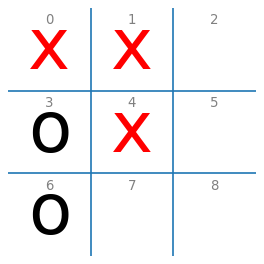


Predicted game outcome: [1]
Predicted probability [loss, draw, win]: [[0.09 0.   0.91]]
Expected utility: +0.83


In [21]:
board = ['x', 'x', ' ',
         'o', 'x', ' ',
         'o', ' ', ' ']

print_eval_board(board)

### x made a mistake and will lose

Board:


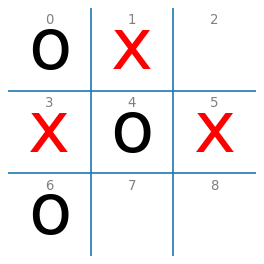


Predicted game outcome: [-1]
Predicted probability [loss, draw, win]: [[0.95 0.01 0.04]]
Expected utility: -0.92


In [22]:
board = ['o', 'x', ' ',
         'x', 'o', 'x',
         'o', ' ', ' ']
    
print_eval_board(board)

### This will be a draw

Board:


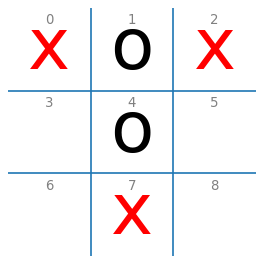


Predicted game outcome: [0]
Predicted probability [loss, draw, win]: [[0.1  0.63 0.27]]
Expected utility: +0.17


In [23]:
board = ['x', 'o', 'x',
         ' ', 'o', ' ',
         ' ', 'x', ' ']

print_eval_board(board)

## Using the Predictions to find the Best Move

The predict function can be used for
   - the heuristic evaluation function for Heuristic Minimax Search.
   - a better playout policy for simulated games used in Pure Monte Carlo Search/Monte Carlo Tree Search. If we use it as a playout strategy to create data for learning better ML models, then this is called _self-play_. 

I show here how to use the model as a heuristic evaluation function for all boards that the player `x` can get to with its next move. The player then chooses the move with the highest heuristic value (printed as "best action").

In [24]:
def eval_fun_ML(state, player = 'x'):
    p = mlp.predict_proba(pd.DataFrame([encode_state(state)]))
    val = np.sum(p * [-1, 0 , 1])
    return val
    

def best_action(state, player = 'x', verbose = False):  
    action = None
    value = -math.inf

    for a in actions(state) : 
        b = result(state, player, a)
        val = eval_fun_ML(b, player)
        if (verbose):
            print("%s chooses %d; expected utility = %+1.2f" % (player, a, val))

        if val > value:
            value = val
            action = a
        
    return action

### Empty board: Place in the center (or at least a corner)

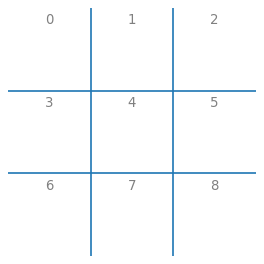

x chooses 0; expected utility = +0.33
x chooses 1; expected utility = +0.19
x chooses 2; expected utility = +0.28
x chooses 3; expected utility = +0.20
x chooses 4; expected utility = +0.51
x chooses 5; expected utility = +0.22
x chooses 6; expected utility = +0.35
x chooses 7; expected utility = -0.01
x chooses 8; expected utility = +0.39
Best action: 4
CPU times: user 31.7 ms, sys: 47.1 ms, total: 78.8 ms
Wall time: 25.6 ms


In [25]:
board = empty_board()
show_board(board)
%time print("Best action:", best_action(board, verbose = True))

### Play 7 to avoid a loss

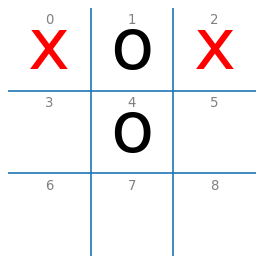

x chooses 3; expected utility = -0.11
x chooses 5; expected utility = -0.40
x chooses 6; expected utility = -0.22
x chooses 7; expected utility = +0.17
x chooses 8; expected utility = -0.25
Best action: 7
CPU times: user 15.4 ms, sys: 10.8 ms, total: 26.3 ms
Wall time: 8.49 ms


In [26]:
board = ['x', 'o', 'x',
         ' ', 'o', ' ',
         ' ', ' ', ' ']
show_board(board)
%time  print("Best action:", best_action(board, verbose = True))

### Play 4 to win

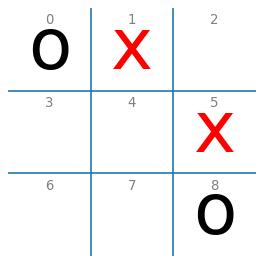

x chooses 2; expected utility = -0.93
x chooses 3; expected utility = -0.44
x chooses 4; expected utility = +0.31
x chooses 6; expected utility = +0.65
x chooses 7; expected utility = -0.23
Best action: 6
CPU times: user 22 ms, sys: 4.3 ms, total: 26.3 ms
Wall time: 8.44 ms


In [27]:
board = ['o', 'x', ' ',
         ' ', ' ', 'x',
         ' ', ' ', 'o']
show_board(board)
%time  print("Best action:", best_action(board, verbose = True))

__Notes:__ 

* The learned evaluation function is not perfect.
* Tic-tac-toe is easy and learning an evaluation function for more complex games can be a lot harder.